In [14]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
from scipy.interpolate import interp1d
import time

nside = 1024
lmax = 1024*3-1

def iqu2teb(IQU, nside, lmax=None):
    print('a')
    alms = hp.map2alm(IQU, lmax=lmax, pol=True)
    print('b')
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=False)

def teb2iqu(TEB, nside, lmax=None):
    alms = hp.map2alm(TEB, lmax=lmax, pol=False)
    return hp.alm2map(alms, nside=nside, lmax=lmax, pol=True)

# Begin in Q, U 
### $a_{Q,U} = R \ a_{E,B} + n_{Q,U}$
### $d_{Q,U} = s_{Q,U} + n_{Q,U}$ 
### $\boldsymbol{d} = \boldsymbol{s} + \boldsymbol{n}$


# Algorithm
### $t = T/(T+N) \ d + \bar{N}/(\bar{N} + T) \  s $
### $ s = S/(S+T) \ t $


# Definitions
### $N_{Q,U} = \langle n_{Q,U} n_{Q,U}^\dagger  \rangle $
### $\bar{N} = N - T$
### $ T = \tau \times \mathbf{1}$ , where $\tau = {\rm{min}} \big( N \big)$

# Signal covariance [EE,BB]

In [2]:
s_cov_diag = np.load('s_cov_EE_1024.npy')
s_cov_diag = np.hstack([s_cov_diag, (s_cov_diag*0.) + np.min(s_cov_diag)*1e-10])

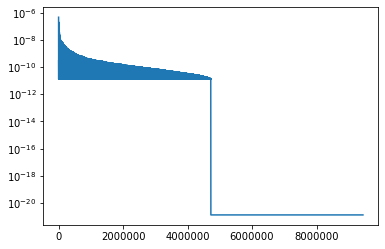

In [3]:
_ = plt.plot(s_cov_diag), plt.yscale('log')

# Data

In [4]:
data_QU = hp.read_map('./map_mock_des1024_QU.fits', field=(0,1))
data_vec = data_QU[0] + 1j* data_QU[1]

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


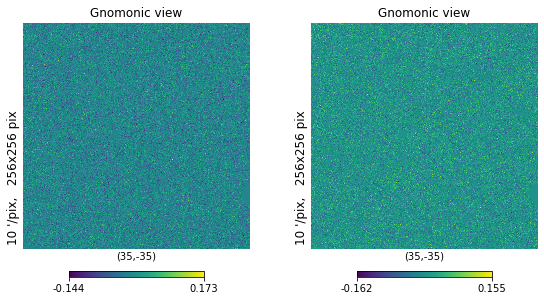

In [5]:
_ = plt.figure(figsize = (12,4)), hp.gnomview(data_vec.real, sub=(1,3,2), reso=10, rot = (35,-35), xsize=256)
_ = hp.gnomview(data_vec.imag, sub=(1,3,3), reso=10, rot = (35,-35), xsize=256)

# Noise covariance $N =  N_{QQ}, N_{UU} $

In [6]:
noise_diag = hp.read_map('map_noise_cov_des1024_QU.fits', field=(0,1))
noise_diag = np.concatenate([noise_diag[0],noise_diag[1]])

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


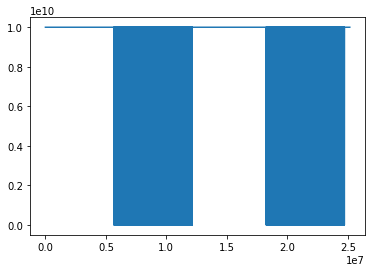

In [16]:
plt.plot(noise_diag)

In [7]:
tau = np.min(noise_diag)
print(tau)
T_pixel = np.ones(noise_diag.shape)*tau
noise_bar_diag = noise_diag - tau

0.00017164225573651493


In [8]:
random_T_field = np.random.normal(0., np.sqrt(tau), hp.nside2npix(nside))

In [9]:
power_t_qq = hp.anafast(hp.ud_grade(random_T_field,nside), lmax = nside*3-1)
power_t_pol = hp.anafast([random_T_field*0.,random_T_field,random_T_field],
                          lmax = nside*3-1, pol = True)
tau_ell = np.mean([power_t_pol[1][50:nside*2], power_t_pol[2][50:nside*2], power_t_qq[50:nside*2]]) 

In [10]:
tau_ell

1.713763065706481e-10

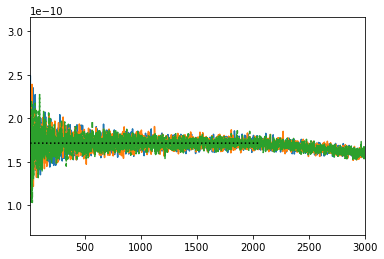

In [11]:
plt.plot(power_t_pol[1])
plt.plot(power_t_pol[2])
plt.plot([tau_ell]*nside*2, ':', c='black')
plt.plot(power_t_qq, '--'), plt.xlim(10,3000)
_ = plt.ylim(np.min(power_t_pol[2][50:nside*2])*0.5,np.max(power_t_pol[2][50:nside*2])*1.5)
plt.plot([tau_ell]*nside*2, ':', c='black')

In [12]:
T_ell = np.ones(s_cov_diag.shape)*tau_ell

# Implementation

In [15]:
n_iter = 50
data_vec_QU = np.concatenate([data_vec.real, data_vec.imag])
s = np.zeros(data_vec_QU.shape, dtype='complex')

convergence_test = [0.]


harmonic_operator = s_cov_diag/(s_cov_diag+T_ell)
pixel_operator_signal = (noise_bar_diag/(noise_bar_diag+T_pixel))
pixel_operator_data = (T_pixel / (T_pixel + noise_diag))


for i in range(n_iter):
    time_counter = time.time()
    
    t = pixel_operator_data * data_vec_QU + pixel_operator_signal*s # here t = concat[t_Q, t_U]
    t = np.real(t)
    t = [t[int(t.shape[0]/2):]*0.,t[:int(t.shape[0]/2)],t[int(t.shape[0]/2):]] # here t = {t_I = 0, t_Q, t_U}
    t = hp.ud_grade(t, nside) # now upgrade
    
    t_alm = hp.map2alm(t, lmax = 3*(nside)-1, pol=True) 
    
    s = harmonic_operator*np.concatenate([t_alm[1], t_alm[2]])
    s = [s[int(s.shape[0]/2):]*0.,s[:int(s.shape[0]/2)],s[int(s.shape[0]/2):]]
    
    print(np.var(s[0]), np.var(s[1]), np.var(s[2]))
    convergence_test.append(np.var(s[1]))
    

    s = hp.alm2map(s, nside=nside, lmax=nside*3-1, verbose=False, pol=True)
    s_qu = np.copy(s)
    s = np.concatenate([s[1], s[2]])
    print(time.time() -time_counter)

0.0 1.915141338146307e-13 1.5305492639115619e-34
569.2302272319794
0.0 3.8283281840760645e-13 1.5278266502591706e-34
630.34961104393
0.0 5.197981262611452e-13 1.5269755302789166e-34
806.5264468193054
0.0 6.189329465085753e-13 1.5265830151122526e-34
801.08016705513
0.0 6.920618549936199e-13 1.5263605308751191e-34
474.09013772010803
0.0 7.468259585521252e-13 1.5262190417797692e-34
442.948655128479
0.0 7.883431315122793e-13 1.5261223921331338e-34
356.4915409088135
0.0 8.201581194099235e-13 1.5260530916649586e-34
347.9392080307007
0.0 8.447839633721436e-13 1.5260016298196302e-34
347.15667724609375
0.0 8.640311650556591e-13 1.5259623865689788e-34
633.4912507534027
0.0 8.792195459323989e-13 1.5259318282702978e-34
806.9757308959961
0.0 8.913202585931915e-13 1.5259076241619369e-34
596.1471929550171
0.0 9.010536233731494e-13 1.525888177643456e-34
376.433758020401
0.0 9.089577969969773e-13 1.5258723612479806e-34
427.58215284347534
0.0 9.154376066804934e-13 1.5258593587708336e-34
389.592518091201

([<matplotlib.lines.Line2D at 0x114c97c50>],
 Text(0, 0.5, 'var'),
 Text(0.5, 0, 'n iteration'))

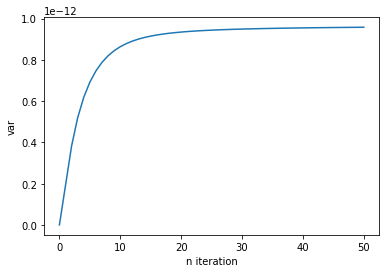

In [29]:
plt.plot(convergence_test), plt.ylabel('var'), plt.xlabel('n iteration')

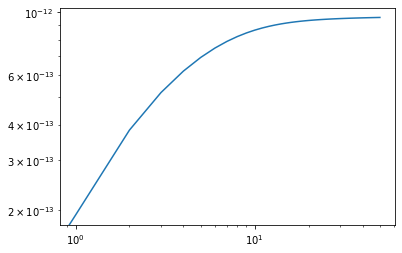

In [28]:
plt.loglog(convergence_test)

In [18]:
s_eb = iqu2teb(s_qu, nside, lmax = nside*3 -1)

a
b
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


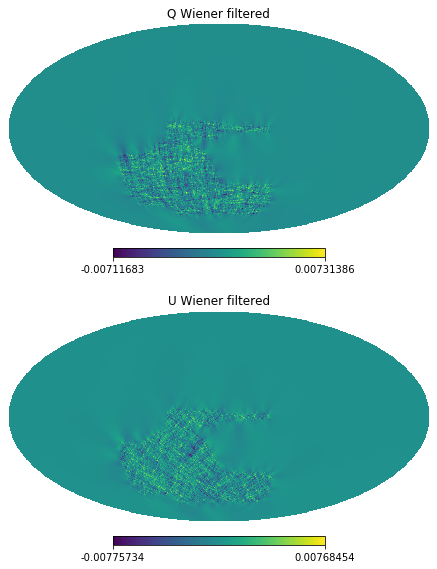

In [19]:
_ = plt.figure(figsize=(6,8))
_ = hp.mollview(s_qu[1], sub=(2,1,1), title='Q Wiener filtered')
_ = hp.mollview(s_qu[2], sub=(2,1,2), title='U Wiener filtered')

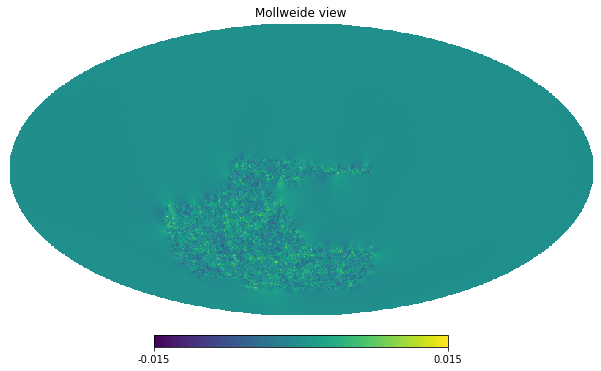

In [24]:
hp.mollview(s_eb[1], min = -0.015, max = 0.015)

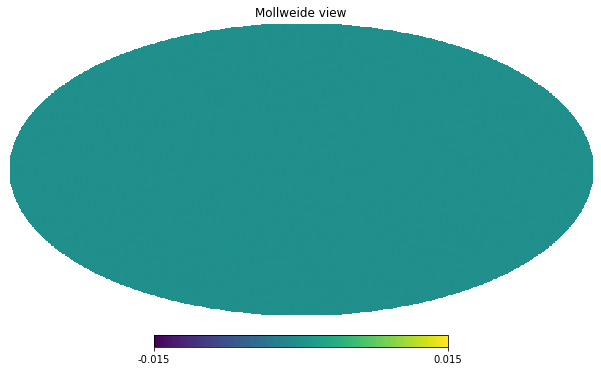

In [27]:
hp.mollview(s_eb[2], min = -0.015, max = 0.015)

In [22]:
np.save('test_wiener2_E_200320', np.array(s_eb[1], dtype = 'float'))